In [76]:
#!pip install git+https://github.com/ai-forever/diffusers.git
!pip install git+https://github.com/huggingface/diffusers.git

!pip install transformers
!pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-yk81ynli
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-yk81ynli
  Resolved https://github.com/huggingface/diffusers.git to commit 7c8cab313e4c66a813d146bcf92023b0489a2369
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [77]:
import sys
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np

DEVICE = torch.device('cuda:0')

In [78]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    'kandinsky-community/kandinsky-2-2-prior',
    subfolder='image_encoder'
).half().to(DEVICE)

In [79]:
unet = UNet2DConditionModel.from_pretrained(
    'kandinsky-community/kandinsky-2-2-decoder', 
    subfolder='unet'
).half().to(DEVICE)

In [80]:
prior = KandinskyV22PriorPipeline.from_pretrained(
    'kandinsky-community/kandinsky-2-2-prior',
    image_encoder=image_encoder, 
    torch_dtype=torch.float16
).to(DEVICE)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [81]:
decoder = KandinskyV22Pipeline.from_pretrained(
    'kandinsky-community/kandinsky-2-2-decoder',
    unet=unet, 
    torch_dtype=torch.float16
).to(DEVICE)

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [82]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("laion/CLIP-ViT-bigG-14-laion2B-39B-b160k")
processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-bigG-14-laion2B-39B-b160k")
#load models

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [83]:
from PIL import Image

image = Image.open('/home/ml1/image2.jpg')
#image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a diagram"], images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

print(logits_per_image)
print(probs)
print(type(outputs))

image_embeds = outputs.image_embeds
print(type(image_embeds))
print(torch.Tensor.size(image_embeds))


in_image_embeds = image_embeds

in_image_embeds2 = outputs.vision_model_output.last_hidden_state

print(torch.Tensor.size(outputs.vision_model_output.last_hidden_state))
#print(torch.Tensor.size(outputs.pooler_output))


tensor([[18.9613, 37.5329]], grad_fn=<TBackward0>)
tensor([[8.5985e-09, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
<class 'transformers.models.clip.modeling_clip.CLIPOutput'>
<class 'torch.Tensor'>
torch.Size([1, 1280])
torch.Size([1, 257, 1664])


In [74]:
#scale the clip values

clip_mean = prior.clip_mean.clone()
clip_std = prior.clip_std.clone()

sample = in_image_embeds
sample = (sample - clip_mean) / clip_std

sample = torch.clamp(sample, -10, 10)

#documentation

#https://github.com/huggingface/diffusers/tree/main/examples/kandinsky2_2/text_to_image

#https://github.com/huggingface/diffusers/blob/main/examples/kandinsky2_2/text_to_image/train_text_to_image_prior.py

#do_normalize (bool, optional, defaults to True) – Whether or not to normalize the input with image_mean and image_std.
#https://huggingface.co/transformers/v4.8.0/model_doc/clip.html
#CLIPFeatureExtractor
#class transformers.CLIPFeatureExtractor(do_resize=True, size=224, resample=3, do_center_crop=True, crop_size=224, do_normalize=True, image_mean=None, image_std=None, **kwargs)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 #scale the clip values                                                                      │
│    2                                                                                             │
│ ❱  3 clip_mean = prior.clip_mean.clone()                                                         │
│    4 clip_std = prior.clip_std.clone()                                                           │
│    5                                                                                             │
│    6 sample = in_image_embeds                                                                    │
│                                                                                                  │
│ /home/ml1/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:138 in            │
│ __getattr__                                                                                      │
│                                                                                                  │
│   135 │   │   │   deprecate("direct config name access", "1.0.0", deprecation_message, standar   │
│   136 │   │   │   return self._internal_dict[name]                                               │
│   137 │   │                                                                                      │
│ ❱ 138 │   │   raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'"   │
│   139 │                                                                                          │
│   140 │   def save_config(self, save_directory: Union[str, os.PathLike], push_to_hub: bool = F   │
│   141 │   │   """                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'KandinskyV22PriorPipeline' object has no attribute 'clip_mean'

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1, 1280])


  0%|          | 0/50 [00:00<?, ?it/s]

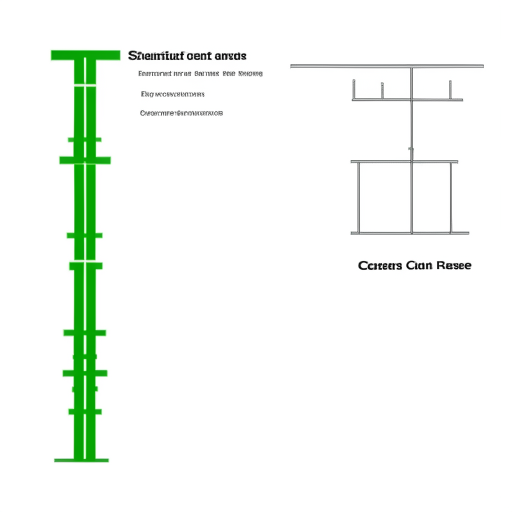

In [85]:
#torch.manual_seed(42)
seed = torch.random.seed()
torch.manual_seed(seed)


#negative_prior_prompt ='lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature'

negative_prior_prompt= ""

in_prompt = "" #'A robot, 4k photo',

''
img_emb = prior(
    prompt=in_prompt,
    num_inference_steps=25, 
    num_images_per_prompt=1
)

negative_emb = prior(
    prompt=negative_prior_prompt,
    num_inference_steps=2, #8
    num_images_per_prompt=1
)

print(torch.Tensor.size(img_emb.image_embeds))


#images = generate_text2img(
    
#images = decoder(image_embeds=img_emb.image_embeds, negative_image_embeds=negative_emb.image_embeds, num_inference_steps=50, height=512, width=512)

#in_prior_guidance_scale = 4
#in_decoder_guidance_scale = 4

in_prior_guidance_scale = 4
in_decoder_guidance_scale = 4

#in_image_embeds

in_image_embeds = in_image_embeds.to(DEVICE)

#images = decoder(image_embeds=in_image_embeds, decoder_guidance_scale=in_decoder_guidance_scale, prior_guidance_scale=in_prior_guidance_scale, negative_image_embeds=negative_emb.image_embeds, num_inference_steps=50, height=512, width=512)

images = decoder(image_embeds=in_image_embeds, decoder_guidance_scale=in_decoder_guidance_scale, prior_guidance_scale=in_prior_guidance_scale, negative_image_embeds=negative_emb.image_embeds, num_inference_steps=50, height=512, width=512)

#images = decoder(image_embeds=img_emb.image_embeds, decoder_guidance_scale=in_decoder_guidance_scale, prior_guidance_scale=in_prior_guidance_scale, negative_image_embeds=negative_emb.image_embeds, num_inference_steps=50, height=512, width=512)


images.images[0]

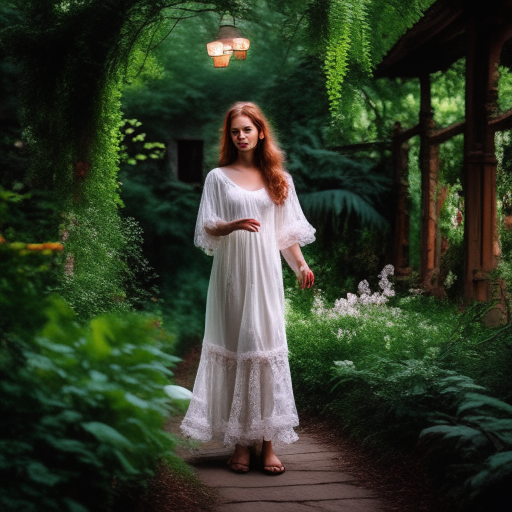

In [7]:
images.images[0]